# 00 - Librerías

In [1]:
import requests
import pandas as pd
import json
from pandas import json_normalize
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import statsmodels.api as sm
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

# 01 - Extracción de Datos

In [2]:
cats = requests.get('http://api.mercadolibre.com/sites/MCO/categories')
cats.json()

[{'id': 'MCO1747', 'name': 'Accesorios para Vehículos'},
 {'id': 'MCO441917', 'name': 'Agro'},
 {'id': 'MCO1403', 'name': 'Alimentos y Bebidas'},
 {'id': 'MCO1071', 'name': 'Animales y Mascotas'},
 {'id': 'MCO1367', 'name': 'Antigüedades y Colecciones'},
 {'id': 'MCO1368', 'name': 'Arte, Papelería y Mercería'},
 {'id': 'MCO1384', 'name': 'Bebés'},
 {'id': 'MCO1246', 'name': 'Belleza y Cuidado Personal'},
 {'id': 'MCO40433', 'name': 'Boletas para Espectáculos'},
 {'id': 'MCO1039', 'name': 'Cámaras y Accesorios'},
 {'id': 'MCO1743', 'name': 'Carros, Motos y Otros'},
 {'id': 'MCO1051', 'name': 'Celulares y Teléfonos'},
 {'id': 'MCO1648', 'name': 'Computación'},
 {'id': 'MCO1144', 'name': 'Consolas y Videojuegos'},
 {'id': 'MCO172890', 'name': 'Construcción'},
 {'id': 'MCO1276', 'name': 'Deportes y Fitness'},
 {'id': 'MCO5726', 'name': 'Electrodomésticos'},
 {'id': 'MCO1000', 'name': 'Electrónica, Audio y Video'},
 {'id': 'MCO175794', 'name': 'Herramientas'},
 {'id': 'MCO1574', 'name': 'Ho

In [3]:
cat_id = 'MCO1051'
df_list=[]
for i in range(0,10):
    offset = 100 * i
    url = f'http://api.mercadolibre.com/sites/MCO/search?category={cat_id}&offset={offset}'
    response = requests.get(url)
    items = response.json()
    if not items['results']:
        break 
    df = pd.json_normalize(items['results'])
    df_list.append(df)

In [4]:
df_final = pd.concat(df_list)
df_final.shape

(500, 70)

# 02 - Preparación de Datos

In [5]:
#Observar con detalle las columnas contenidas en el dataframe
print(df_final.columns.values)
type(df_final.columns.values)

['id' 'site_id' 'title' 'price' 'sale_price' 'currency_id'
 'available_quantity' 'sold_quantity' 'buying_mode' 'listing_type_id'
 'stop_time' 'condition' 'permalink' 'thumbnail' 'thumbnail_id'
 'accepts_mercadopago' 'attributes' 'original_price' 'category_id'
 'official_store_id' 'domain_id' 'catalog_product_id' 'tags'
 'catalog_listing' 'use_thumbnail_id' 'offer_score' 'offer_share'
 'match_score' 'winner_item_id' 'melicoin' 'discounts' 'order_backend'
 'seller.id' 'seller.permalink' 'seller.registration_date'
 'seller.car_dealer' 'seller.real_estate_agency' 'seller.tags' 'prices.id'
 'prices.prices' 'prices.presentation.display_currency'
 'prices.payment_method_prices' 'prices.reference_prices'
 'prices.purchase_discounts' 'installments.quantity' 'installments.amount'
 'installments.rate' 'installments.currency_id' 'address.state_id'
 'address.state_name' 'address.city_id' 'address.city_name'
 'shipping.free_shipping' 'shipping.mode' 'shipping.tags'
 'shipping.logistic_type' 'shippin

numpy.ndarray

Verificamos un id en la referencia de la api, para conocer la estructura y contenido de las variables
https://api.mercadolibre.com/items/MCO820102385#options

Allí encontramos que existen algunas columnas como tipo lista: attributes, tags, prices.prices, prices.payment_method_prices, prices.reference_prices, prices.purchase_discounts, shipping.tags. Estas columnas las vamos a eliminar para estudiar en primera instancia el resto de columnas.

In [6]:
#Eliminar columnas tipo listas
df_final = df_final.drop(['attributes','tags','prices.prices','prices.payment_method_prices','prices.reference_prices',
                          'prices.purchase_discounts','shipping.tags'], axis=1)

In [7]:
#Verificamos cantidad de valores distintos que existen en cada columna
n = pd.DataFrame(df_final.nunique(axis=0))
n_1 = n[n[0] == 1]
n_1 = n_1.reset_index()
n_2 = n_1.drop([0], axis=1)
n_2 = n_2.to_numpy().tolist()
#Vamos a eliminar aquellas variables donde sólo tengan 1 valor diferente dentro de la columna, esto motivado a que
#no nos va a brindar información relevante en el modelado
df_final_1 = df_final.drop(['site_id','currency_id','buying_mode','condition','accepts_mercadopago','catalog_listing',
                          'seller.car_dealer','seller.real_estate_agency','prices.presentation.display_currency',
                          'installments.rate','installments.currency_id','shipping.mode','shipping.store_pick_up',
                          'seller_address.id','seller_address.comment','seller_address.address_line','seller_address.zip_code',
                          'seller_address.latitude','seller_address.longitude','differential_pricing.id'], axis=1)
df_final_1.shape

(500, 43)

In [8]:
print(df_final_1.columns.values)
type(df_final_1.columns.values)

['id' 'title' 'price' 'sale_price' 'available_quantity' 'sold_quantity'
 'listing_type_id' 'stop_time' 'permalink' 'thumbnail' 'thumbnail_id'
 'original_price' 'category_id' 'official_store_id' 'domain_id'
 'catalog_product_id' 'use_thumbnail_id' 'offer_score' 'offer_share'
 'match_score' 'winner_item_id' 'melicoin' 'discounts' 'order_backend'
 'seller.id' 'seller.permalink' 'seller.registration_date' 'seller.tags'
 'prices.id' 'installments.quantity' 'installments.amount'
 'address.state_id' 'address.state_name' 'address.city_id'
 'address.city_name' 'shipping.free_shipping' 'shipping.logistic_type'
 'seller_address.country.id' 'seller_address.country.name'
 'seller_address.state.id' 'seller_address.state.name'
 'seller_address.city.id' 'seller_address.city.name']


numpy.ndarray

### Verificación de las variables restantes y evaluar cuáles no son necesarias:
Las siguientes columnas se consideran no necesarias por varios motivos:
1)No se encontró la explicación de la variable en la documentación del link https://api.mercadolibre.com/items/MCO820102385#options
2)No es requerido para el modelo que se quiere plantear
3)No tiene información (None)

id, title, listing_type_id, stop_time, permalink, thumbnail, thumbnail_id, official_store_id, domain_id, catalog_product_id, seller.permalink, price.id, offer_score, offer_share, match_score, winner_item_id, melicoin, order_backend, seller.registration_date, seller.tags

In [9]:
df_final_1 = df_final_1.drop(['id','title','listing_type_id','stop_time','permalink','thumbnail',
                          'thumbnail_id','official_store_id','domain_id','catalog_product_id','seller.permalink',
                          'prices.id','offer_score','offer_share','match_score','winner_item_id','melicoin',
                          'order_backend','seller.registration_date','seller.tags'], axis=1)
df_final_1.shape

(500, 23)

In [10]:
print(df_final_1.columns.values)
type(df_final_1.columns.values)

['price' 'sale_price' 'available_quantity' 'sold_quantity'
 'original_price' 'category_id' 'use_thumbnail_id' 'discounts' 'seller.id'
 'installments.quantity' 'installments.amount' 'address.state_id'
 'address.state_name' 'address.city_id' 'address.city_name'
 'shipping.free_shipping' 'shipping.logistic_type'
 'seller_address.country.id' 'seller_address.country.name'
 'seller_address.state.id' 'seller_address.state.name'
 'seller_address.city.id' 'seller_address.city.name']


numpy.ndarray

In [11]:
#Mostrar tipo de datos de cada columna e indicar cantidad de nulos
tab_info=pd.DataFrame(df_final_1.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_final_1.isnull().sum()).T.rename(index={0:'null values (nb)'}))
display(tab_info)

,price,sale_price,available_quantity,sold_quantity,original_price,category_id,use_thumbnail_id,discounts,seller.id,installments.quantity,...,address.city_id,address.city_name,shipping.free_shipping,shipping.logistic_type,seller_address.country.id,seller_address.country.name,seller_address.state.id,seller_address.state.name,seller_address.city.id,seller_address.city.name
column type,int64,object,int64,int64,float64,object,bool,object,int64,int64,...,object,object,bool,object,object,object,object,object,object,object
null values (nb),0,500,0,0,396,0,0,500,0,0,...,0,0,0,0,0,0,0,0,0,0


Se eliminarán las columnas sale_price, discounts y original_price, dado que tienen mayor cantidad de nulos, lo cual no nos da información relevante.

In [12]:
df_final_1 = df_final_1.drop(['sale_price','discounts','original_price'], axis=1)
df_final_1.shape

(500, 20)

In [13]:
#Eliminación de vacíos
df_final_1.dropna(axis = 0, subset = ['seller.id'], inplace = True)
print('Dataframe dimensions:', df_final_1.shape)

Dataframe dimensions: (500, 20)


In [14]:
#Verificar si existen duplicados y eliminarlos
df_final_1.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
df_final_1.shape

(500, 20)

# 03 - Exploratorios

In [15]:
#Estadísticas descriptivas
df_num = df_final_1.loc[:,['price', 'available_quantity', 'sold_quantity','installments.quantity', 'installments.amount']]
df_num.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,500.0,1.045671e+06,1.558718e+06,5000.00,89900.000,593950.00,1.232422e+06,16599000.0
available_quantity,500.0,8.313400e+01,4.041936e+02,1.00,1.000,1.00,1.525000e+01,5000.0
sold_quantity,500.0,1.308120e+02,3.851158e+02,0.00,2.000,5.00,1.082500e+02,5000.0
installments.quantity,500.0,3.168000e+01,9.229733e+00,12.00,36.000,36.00,3.600000e+01,36.0
installments.amount,500.0,3.420750e+04,6.154152e+04,138.89,3332.015,17234.49,3.621250e+04,575825.0


Con estas descriptivas básicas podemos observar de cierta manera como es la distribución de estas variables numéricas, para tener una mejor perspectiva se construyen los gráficos.

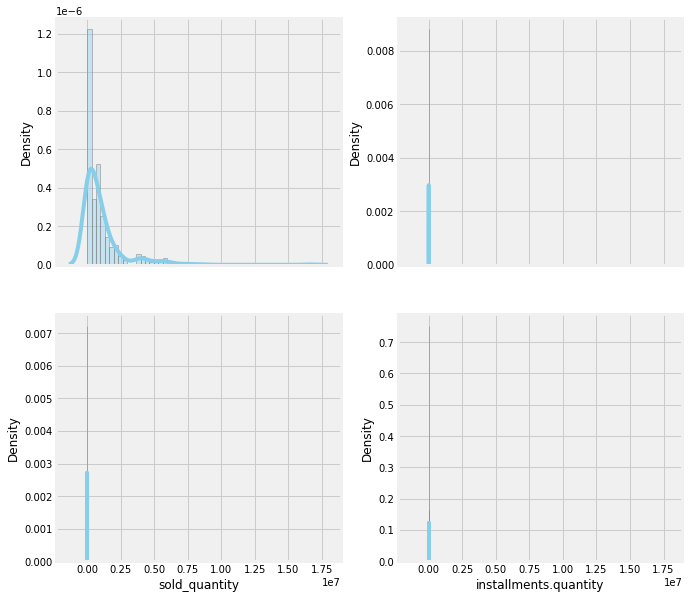

In [16]:
#Distribución de las variables numéricas
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
for ax, feature in zip(axes.flat, df_num.columns):
    sns.distplot(df_num[feature] , color="skyblue", ax=ax)

Observamos que de las variables numéricas, la variable price nos muestra una distribución sesgada a la derecha con concentración en valores pequeños desde el minimo que se encuentra en 4990 COP hasta la mediana que se encuentra en 554.450 COP, como estamos en la categoría de "Celulares y Teléfonos" como hipótesis tenemos que en esa categoría también ingresan los accesorios de los celulares, teniendo esos montos tan bajos. 
Para las otras variables, si se presenta una distribución, sin embargo, en el agrupamiento de las gráficas no permite visualizar adecuadamente el comportamiento.

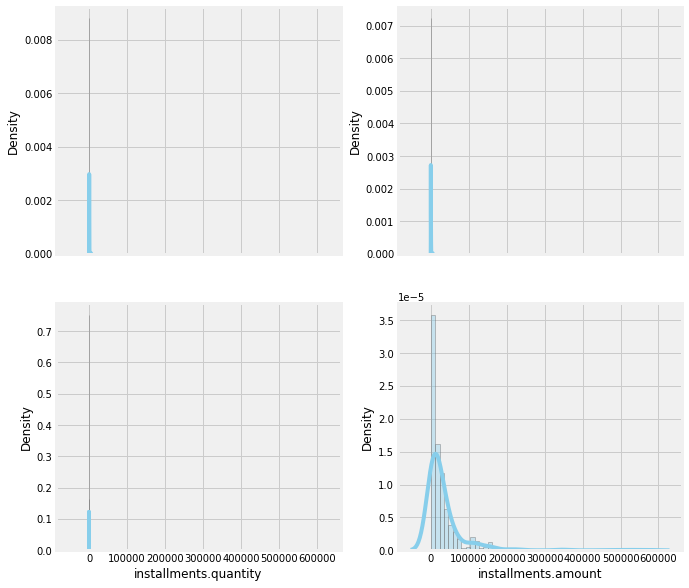

In [17]:
df_num_1 = df_final_1.loc[:,['available_quantity', 'sold_quantity','installments.quantity', 'installments.amount']]
#Distribución de las variables numéricas
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
for ax, feature in zip(axes.flat, df_num_1.columns):
    sns.distplot(df_num_1[feature] , color="skyblue", ax=ax)

Para comprobar la hipótesis sobre la variable price, buscaremos el artículo con el precio minimo y observaremos el title y demás datos.

In [18]:
price_min = df_final[df_final['price'] <= 5000]
price_min

,id,site_id,title,price,sale_price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,...,seller_address.zip_code,seller_address.country.id,seller_address.country.name,seller_address.state.id,seller_address.state.name,seller_address.city.id,seller_address.city.name,seller_address.latitude,seller_address.longitude,differential_pricing.id
36,MCO593295410,MCO,Adaptador Convertidor Usb 3.0 Hembra Otg A Tip...,5000,None,COP,100,250,buy_it_now,gold_special,...,,CO,Colombia,CO-ANT,Antioquia,TUNPQ01FRGRjNjc4,Medellín,,,NaN


Efectivamente, corresponden a accesorios o piezas menores dentro de la categoría

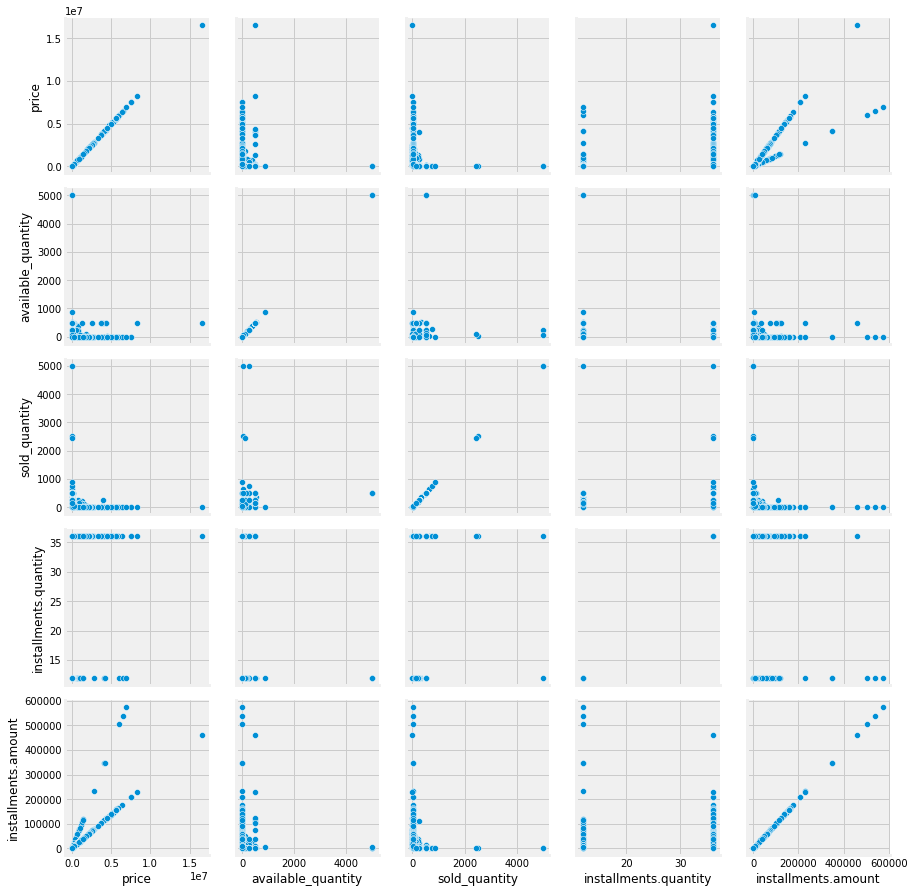

In [19]:
#Relación de las variables
g = sns.PairGrid(df_num)
g.map(sns.scatterplot)

<AxesSubplot:>

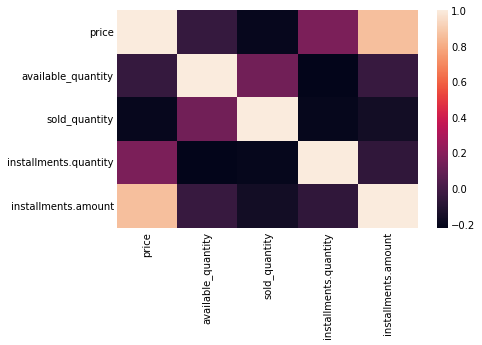

In [20]:
#Matriz de correlaciones
sns.heatmap(df_num.corr())

En estas gráficas de correlaciones podemos decir que:

-Bajas correlaciones (entre -0.2 y 0.4)
available_quantity con el resto de variables
sold_quantity con el resto de variables
installments_quantity con el resto de variables
installments_amount con el resto de variables, excepto price

-Altas correlaciones (>0.4)
installments_amount con price

In [21]:
temp = pd.DataFrame(df_final_1.groupby(['seller.id']).agg({'sold_quantity':'count','price':'sum','available_quantity':'sum'}))
temp = temp.reset_index()
temp['avg_price_sold'] = temp['price']/temp['sold_quantity']
temp['rate_quan'] = temp['sold_quantity']/temp['available_quantity']
temp.sort_values(by=['sold_quantity'], inplace=True, ascending=False)
temp

,seller.id,sold_quantity,price,available_quantity,avg_price_sold,rate_quan
62,162681369,39,77023496,72,1.974961e+06,0.541667
168,1059924855,24,14190500,90,5.912708e+05,0.266667
109,406781619,17,17085899,22,1.005053e+06,0.772727
106,394887418,16,23110400,263,1.444400e+06,0.060837
148,689840781,15,36865593,24,2.457706e+06,0.625000
...,...,...,...,...,...,...
58,147458773,1,1584000,9,1.584000e+06,0.111111
57,146059566,1,700000,4,7.000000e+05,0.250000
55,142097904,1,139000,8,1.390000e+05,0.125000
52,135462891,1,117710,1,1.177100e+05,1.000000


In [22]:
tmp_1 = temp[temp['sold_quantity'] > 1]
tmp_1

,seller.id,sold_quantity,price,available_quantity,avg_price_sold,rate_quan
62,162681369,39,77023496,72,1.974961e+06,0.541667
168,1059924855,24,14190500,90,5.912708e+05,0.266667
109,406781619,17,17085899,22,1.005053e+06,0.772727
106,394887418,16,23110400,263,1.444400e+06,0.060837
148,689840781,15,36865593,24,2.457706e+06,0.625000
...,...,...,...,...,...,...
43,113378453,2,2334800,2,1.167400e+06,1.000000
141,625814520,2,84800,2,4.240000e+04,1.000000
88,278971153,2,172000,12,8.600000e+04,0.166667
172,1095422460,2,1406900,250,7.034500e+05,0.008000


En esta tabla podemos observar por vendedor, cómo es su comportamiento tanto en precio promedio vendido y en las unidades que posee, viendo que existen apenas un 45% (79/173) de los vendedores con más de 1 artículo vendido. Así mismo, de ese subgrupo de vendedores la distribución de la tasa de cantidades vendidas/cantidades disponibles se observa que, existen vendedores donde tienen mucho stock y viceversa.

<AxesSubplot:xlabel='rate_quan', ylabel='Density'>

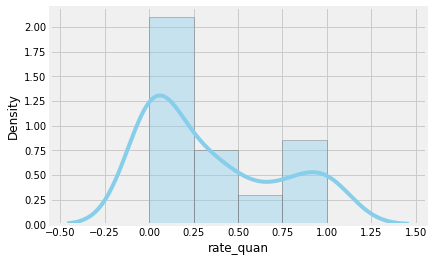

In [23]:
sns.distplot(tmp_1['rate_quan'] , color="skyblue")

In [24]:
temp_2 = pd.DataFrame(df_final_1.groupby('address.state_name')['seller.id'].nunique())
temp_2.sort_values(by=['seller.id'], inplace=True, ascending=False)
temp_2

,seller.id
address.state_name,
Bogotá D.C.,112
Antioquia,26
Cundinamarca,11
Valle Del Cauca,6
Atlantico,5
Santander,5
Risaralda,3
Boyaca,1
Guangdong,1


In [25]:
temp_3 = pd.DataFrame(df_final_1.groupby('seller_address.state.name')['seller.id'].nunique())
temp_3.sort_values(by=['seller.id'], inplace=True, ascending=False)
temp_3

,seller.id
seller_address.state.name,
Bogotá D.C.,112
Antioquia,26
Cundinamarca,11
Valle Del Cauca,6
Atlantico,5
Santander,5
Risaralda,3
Boyaca,1
Guangdong,1


In [26]:
sum(temp_3['seller.id'])

174

Observamos que las dos variables de estado tienen la misma distribución, por lo tanto, sólo usaremos una de ellas. Adicionalmente, Bogotá DC tiene el 64% (112/173) de los vendedores.

In [27]:
temp_4 = pd.DataFrame(df_final_1.groupby('category_id')['seller.id'].nunique())
temp_4.sort_values(by=['seller.id'], inplace=True, ascending=False)
temp_4

,seller.id
category_id,
MCO1055,79
MCO5072,29
MCO118449,24
MCO7908,16
MCO169817,9
MCO39268,7
MCO434353,7
MCO2896,5
MCO4922,4


In [28]:
temp_5 = pd.DataFrame(df_final_1.groupby('use_thumbnail_id')['seller.id'].nunique())
temp_5.sort_values(by=['seller.id'], inplace=True, ascending=False)
temp_5

,seller.id
use_thumbnail_id,
False,115
True,99


In [29]:
temp_6 = pd.DataFrame(df_final_1.groupby('shipping.free_shipping')['seller.id'].nunique())
temp_6.sort_values(by=['seller.id'], inplace=True, ascending=False)
temp_6

,seller.id
shipping.free_shipping,
True,124
False,61


In [30]:
temp_7 = pd.DataFrame(df_final_1.groupby('shipping.logistic_type')['seller.id'].nunique())
temp_7.sort_values(by=['seller.id'], inplace=True, ascending=False)
temp_7

,seller.id
shipping.logistic_type,
xd_drop_off,75
cross_docking,54
drop_off,29
fulfillment,24


# 04 - Transformaciones

1) Selección de variables dejando:
avg_price_sold, rate_quan, installments.quantity, installments.amount. El resto no serán consideradas por el poco valor que le pueden agregar al modelo.

2) Transformaciones a realizar

Normalizar las variables numéricas, de forma tal que, los clústers no sufran distorsionen por las escalas de valores de las variables. Para ello, utilizaremos una normalización en función de la media y la desviación estándar.

In [31]:
#Dataset para modelo
data_modelo = pd.DataFrame(df_final_1.groupby(['seller.id']).agg({'sold_quantity':'count','price':'sum','available_quantity':'sum', 'installments.amount': 'sum', 'installments.quantity': 'sum'}))
data_modelo = data_modelo.reset_index()
data_modelo['avg_price_sold'] = data_modelo['price']/data_modelo['sold_quantity']
data_modelo['rate_quan'] = data_modelo['sold_quantity']/data_modelo['available_quantity']
data_modelo.sort_values(by=['sold_quantity'], inplace=True, ascending=False)
data_modelo = data_modelo.drop(['sold_quantity','price','available_quantity'], axis=1)
data_modelo

,seller.id,installments.amount,installments.quantity,avg_price_sold,rate_quan
62,162681369,2290885.77,1356,1.974961e+06,0.541667
168,1059924855,394180.56,864,5.912708e+05,0.266667
109,406781619,530719.40,588,1.005053e+06,0.772727
106,394887418,873005.56,552,1.444400e+06,0.060837
148,689840781,1024044.26,540,2.457706e+06,0.625000
...,...,...,...,...,...
58,147458773,44000.00,36,1.584000e+06,0.111111
57,146059566,58333.33,12,7.000000e+05,0.250000
55,142097904,3861.11,36,1.390000e+05,0.125000
52,135462891,3269.72,36,1.177100e+05,1.000000


In [32]:
#Normalización
data_modelo_1 = data_modelo.drop(['seller.id'], axis=1)
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

data_modelo_norm = mean_norm(data_modelo_1)
data_modelo_norm

,installments.amount,installments.quantity,avg_price_sold,rate_quan
62,7.111573,8.265560,1.558996,0.284966
168,0.959685,5.050725,0.037714,-0.367282
109,1.402543,3.247281,0.492642,0.832997
106,2.512735,3.012049,0.975677,-0.855471
148,3.002623,2.933638,2.089744,0.482616
...,...,...,...,...
58,-0.176111,-0.359607,1.129158,-0.736230
57,-0.129622,-0.516429,0.157255,-0.406812
55,-0.306300,-0.359607,-0.459530,-0.703288
52,-0.308219,-0.359607,-0.482937,1.372045


# 05 - Modelo

El modelo que utilizaremos será K-means con distancia euclideana.

In [33]:
matrix = data_modelo_norm.to_numpy()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.5710375778696443
For n_clusters = 4 The average silhouette_score is : 0.5788261146306435
For n_clusters = 5 The average silhouette_score is : 0.5927544227217512
For n_clusters = 6 The average silhouette_score is : 0.6087952291391605
For n_clusters = 7 The average silhouette_score is : 0.5910326000827103
For n_clusters = 8 The average silhouette_score is : 0.5056539040965515
For n_clusters = 9 The average silhouette_score is : 0.5083440699666968


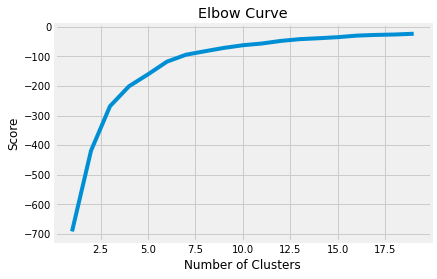

In [34]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(matrix).score(matrix) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Con estas dos metodologías (silhouette y la elbow curve) podremos escoger el número de clústers adecuado. 
Por el silhouette_score se sabe que es mejor cuando es 1 (https://runebook.dev/es/docs/scikit_learn/modules/generated/sklearn.metrics.silhouette_score#:~:text=El%20mejor%20valor%20es%201,en%20la%20Gu%C3%ADa%20del%20usuario%20), en este caso el más cercano a 1 son 5 clústers.
Por la gráfica de la elbow curve ligeramente se observa una inflexión en 3.

Dado que se tiene dudas en cual número de clústers escoger, probaremos ambas opciones y miraremos la cantidad de elementos que tendrían cada clúster.

In [35]:
#Clusters 3
kmeans = KMeans(n_clusters=3).fit(matrix)
clusters_3 = kmeans.predict(matrix)
pd.Series(clusters_3).value_counts()

0    102
2     58
1     14
dtype: int64

In [36]:
#Clusters 5
kmeans = KMeans(n_clusters=5).fit(matrix)
clusters_5 = kmeans.predict(matrix)
pd.Series(clusters_5).value_counts()

0    101
1     57
3     10
4      4
2      2
dtype: int64

Cómo se observa es más conveniente escoger 3 clúster dado que al escoger 5, hay dos grupos con pocos elementos (posibles outliers), lo cual no nos proporcionará información certera del grupo.


In [37]:
#Centroides
kmeans = KMeans(n_clusters=3).fit(matrix)
clusters = kmeans.predict(matrix)
pd.Series(clusters).value_counts()

centroids = kmeans.cluster_centers_
print(centroids)

[[-0.24128881 -0.19821846 -0.27775919 -0.71290313]
 [ 2.60235857  2.36796185  2.35329515 -0.06197412]
 [-0.20316267 -0.22342044 -0.0760866   1.30345018]]


Descriptivos de los clusters de acuerdo con los centroides

- Gruopo 0 (Sellers Bronce): Sellers con bajos installments en cantidad y montos, bajo promedio de venta y bajas tasas de vendido/disponible Corresponde al 58.3% de los sellers (101/173).

- Grupo 1 (Sellers Plata): Sellers installments amount medio, bajo installments quantity, promedio de venta intermedio y rate quant alto. Corresponde al 7.5% de los sellers (13/173).

- Grupo 2 (Sellers Oro): Sellers con mayores valores en installments amount, quantity y precio promedio vendido, mientras que la rate es baja. Corresponde al 34.1% de los sellers (59/173).

El nombre de los grupos basados en el precio promedio.

In [38]:
#Etiquetado del grupo para cada registro
num_cluster = kmeans.predict(matrix)
num_cluster
data_modelo['num_cluster'] = num_cluster
data_modelo

,seller.id,installments.amount,installments.quantity,avg_price_sold,rate_quan,num_cluster
62,162681369,2290885.77,1356,1.974961e+06,0.541667,1
168,1059924855,394180.56,864,5.912708e+05,0.266667,1
109,406781619,530719.40,588,1.005053e+06,0.772727,1
106,394887418,873005.56,552,1.444400e+06,0.060837,1
148,689840781,1024044.26,540,2.457706e+06,0.625000,1
...,...,...,...,...,...,...
58,147458773,44000.00,36,1.584000e+06,0.111111,0
57,146059566,58333.33,12,7.000000e+05,0.250000,0
55,142097904,3861.11,36,1.390000e+05,0.125000,0
52,135462891,3269.72,36,1.177100e+05,1.000000,2


# 07 - Conclusiones

Con la técnica utilizada de escoger las variables más relevantes, que en este caso fueron 4, logramos obtener resultados coherentes para la cantidad de datos que se tenian.

Adicionalmente, la solución planteada da una clasificación de los sellers de forma tal que, el equipo comercial pueda generar estrategias en función del grupo, como por ejemplo: incrementar ventas con el grupo de vendedores que más precio promedio de venta tiene y realizar incentivos, así como también hacer estrategias por la rotación de los artículos, etc.

# 08 - Siguientes Pasos

1) Probar con otras variables.
2) Agregar iteraciones con otros modelos de clusterización.
3) Aplicar a otras categorías.
4) Aplicar a otros países.